# Adversarial Autoencoder Tutorial
By Trace Russell


In this tutorial, I will walk through an implementation of adversarial autoencoders, and discuss some of their interesting properties and use cases. The adversarial autoencoder [1] is a recently developed extension to normal autoencoders that uses adversarial training [2] to regularize the aggregated posterior of the latent variables.

A normal autoencoder is an unsupervised neural network model that learns to compactly encode its inputs. Inputs to the network (e.g. images) are passed though an encoder network that outputs a compact latent code, often called z. The code is then fed through a decoder network, producing a reconstruction of the image. The encoder and decoder are optimized jointly to minimize the mean squared error between the input images and the reconstructions. Because the latent code z has much lower dimensionality than the images themselves, the autoencoder must learn to extract and compose high-level image features in order to make good reconstructions. Because of this property, autoencoders have been successfully used for unsupervised feature learning.

One weakness of normal autoencoders is that they do not impose any way in which the latent code space should be used. Suppose we take a probabilistic view of things, and consider z to be a vector of latent variables that compactly explains the variation between training images. We would like to assume some very simple prior distribution for the latent variables, for instance a Gaussian with an identity covariance matrix, or a uniform distribution. In other words, we might like it to be the case that after training an autoencoder, we can run a bunch of images through it to get their latent codes, and the distribution of these codes would approximately match the prior. In mathematical terms, this mean the aggregated posterior distribution over the latent variables matches the imposed prior. Unfortunately, a normal autoencoder makes no guarantee that this will be the case, and in practice this will almost never happen.

An adversarial autoencoder uses adversarial training to force the aggregated posterior to match the prior, in addition to minimizing the normal mean square error reconstruction loss. The adversarial training process works by creating a discriminator network, that takes as input either latent codes z that come from real images, or samples of z from a prior distribution. The discriminator network outputs the probability that z was sampled from the prior, rather than being a real image encoding. The discriminator network is trained to optimally distinguish these two cases, while the encoder network is trained to produce latent codes z that the discriminator thinks were sampled from the prior. These competing objective functions are where the term 'adversarial' comes in. Convergence occurs when the encoder produces encodings z that are indistiguishable from samples from the prior, which is the property that we seek.

This tutorial uses the TensorFlow deep learning framework, which can be installed by following the instructions [here](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html).

First, we will make the necessary imports and define some constants.

In [56]:
%matplotlib inline

import matplotlib.pyplot as plt
from sys import stdout
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops

LEARNING_RATE = 0.001
STEPS = 10000
BATCH_SIZE = 64
Z_SIZE = 2

We will be using the MNIST dataset. The following code will automatically download the dataset into a folder named 'MNIST_data' in the current directory, and load the data in a suitable format.

In [57]:
from tensorflow.contrib.learn.python.learn.datasets import mnist
data = mnist.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's visualize a single example to make sure everything downloaded and loaded correctly.

(55000, 784)


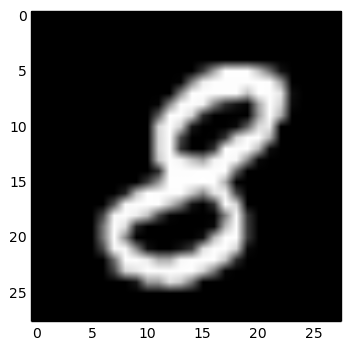

In [58]:
train_images = data.train.images
print train_images.shape
im = train_images[5].reshape((28, 28))
plot = plt.imshow(im, cmap='gray')

Now, we will define the architecture of our neural network. This consists of three subnetworks: the encoder, the decoder, and the discriminator. The encoder and decoder together form the autoencoder part, and the discriminator is used to drive the adversarial training process.

In [47]:
UNITS = 1024
DISCRIM_UNITS = 128

def encoder(x):
    with tf.variable_scope('encoder'):
        with slim.arg_scope([slim.fully_connected], 
                            activation_fn=tf.nn.relu):
            tmp = slim.stack(x, slim.fully_connected, 4*[UNITS])
            mu = slim.fully_connected(tmp, Z_SIZE, activation_fn=None)
            log_sigma = slim.fully_connected(tmp, Z_SIZE, activation_fn=None)
    return mu, log_sigma

def decoder(z):
    with tf.variable_scope('decoder'):
        with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose], 
                            activation_fn=tf.nn.relu):
            tmp = slim.stack(z, slim.fully_connected, 4*[UNITS])
            x_decoded = slim.fully_connected(tmp, 28*28, activation_fn=tf.nn.sigmoid)
    return x_decoded

def discriminator(z, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        with slim.arg_scope([slim.fully_connected], 
                            activation_fn=tf.nn.relu):
            tmp = slim.stack(z, slim.fully_connected, 3*[DISCRIM_UNITS])
            output = slim.fully_connected(tmp, 1, activation_fn=None)
    return output

Now we will connect the subnetworks together. The variable x is our input images, which we create as a placeholder node since we will feed in the values when we actually run our computational graph. Of note here is the reuse argument for the discriminator network, which is necessary between we technically create two different discriminators, one for the encoded z values and one for the sampled values. However, we want these two discriminator networks to share all trainable parameters, so that they act like a single network that is run with two different types of input.

It is also worth noting that the encoder is probabilistic, and hence it actually outputs a vector of means and standard deviations of a diagonal covariance Gaussian distribution. We get the actual z value by sampling from this distribution. We do this by using the reparameterization trick, where we first sample some noise from a zero mean, unit variance Gaussian, multiply the noise by the predicted standard deviation, and finally add the predicted mean.

In [48]:
ops.reset_default_graph()
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 28*28])
mu, log_sigma = encoder(x)
eps = tf.truncated_normal([tf.shape(mu)[0], Z_SIZE])
z = mu + eps*tf.exp(log_sigma)
x_decoded = decoder(z)
z_sampled = tf.random_uniform([BATCH_SIZE, Z_SIZE], minval=-10, maxval=10)

real_logits = discriminator(z_sampled)
fake_logits = discriminator(z, reuse=True)

Now we will create all of our loss functions. The real_loss and fake_loss terms are both cross entropy losses. We want the discriminator network to output 1 for sampled values of z, and 0 for values of z produced by encoding images, which is what these two losses reflect. The total discriminator loss is just the sum of real_loss and fake_loss.

The generator loss is also a cross entropy loss, which optimizes the encoder to produce values of z that the discriminator thinks came from sampling the prior.

Lastly, the reconstruction loss is just the mean squared error between the images and their reconstructions.

We create three training ops, each of which runs a single gradient step to optimize some subset of the networks. The generator train op trains the encoder to produce values of z that the discriminator thinks were sampled from the prior. The discriminator train op trains the discriminator to distiguish between encoded values of z and sampled values of z. The autoencoder train op trains the encoder and decoder jointly to minimize reconstruction error.

In [49]:
real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits, tf.ones_like(real_logits)))
fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.zeros_like(fake_logits)))
discriminator_loss = tf.add(real_loss, fake_loss)
generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.ones_like(fake_logits)))

reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded))

generator_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'encoder')
discriminator_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')

def opt(lr): return tf.train.AdamOptimizer(lr)
generator_train_op = (opt(LEARNING_RATE)
                      .minimize(generator_loss, var_list=generator_variables))
discriminator_train_op = (opt(LEARNING_RATE)
                          .minimize(discriminator_loss, var_list=discriminator_variables))
autoencoder_train_op = opt(LEARNING_RATE).minimize(reconstruction_loss)

Now we train the model. We first run a special op that initializes all variables in the model. Then, each execution of the for loop trains the entire model for a single step using gradient descent. A single iteration consists of running each of our three train ops once on a batch of examples. We use the feed_dict argument to 'inject' a batch of training examples into the graph.

In [50]:
sess.run(tf.initialize_all_variables())

print 'Step  |  Reconstruction Loss  |  Generator Loss  |  Discriminator Loss'
for i in xrange(STEPS):
    batch = data.train.next_batch(BATCH_SIZE)
    _, ae_loss_value = sess.run([autoencoder_train_op, reconstruction_loss], feed_dict={x: batch[0]})
    assert not np.isnan(ae_loss_value), 'Model diverged with NaN loss value'
    _, gen_loss_value = sess.run([generator_train_op, generator_loss], feed_dict={x: batch[0]})
    assert not np.isnan(gen_loss_value), 'Model diverged with NaN loss value'
    _, discrim_loss_value = sess.run([discriminator_train_op, discriminator_loss], feed_dict={x: batch[0]})
    assert not np.isnan(discrim_loss_value), 'Model diverged with NaN loss value'
    if i % 100 == 0:
        stdout.write('\r%d\t %f                %f           %f' %
                     (i, ae_loss_value, gen_loss_value, discrim_loss_value))
        stdout.flush()

Step  |  Reconstruction Loss  |  Generator Loss  |  Discriminator Loss
9900	 0.048636                0.726898           1.357368

Now we will run some images from the validation set through the encoder, and plot the distribution of z values. First, we make a function so that we can color-code z points according to the label of the corresponding image. Do note, however, that using the label information is only for our own visualization purposes. The adversarial autoencoder is an unsupervised method, and does not have access to any label information.

In [7]:
def label_batch_to_colors(labels):
    colors = []
    for label in labels:
        if label == 0:
            colors.append('blue')
        elif label == 1:
            colors.append('green')
        elif label == 2:
            colors.append('red')
        elif label == 3:
            colors.append('teal')
        elif label == 4:
            colors.append('purple')
        elif label == 5:
            colors.append('gold')
        elif label == 6:
            colors.append('black')
        elif label == 7:
            colors.append('olive')
        elif label == 8:
            colors.append('lightsteelblue')
        elif label == 9:
            colors.append('gray')
    return colors

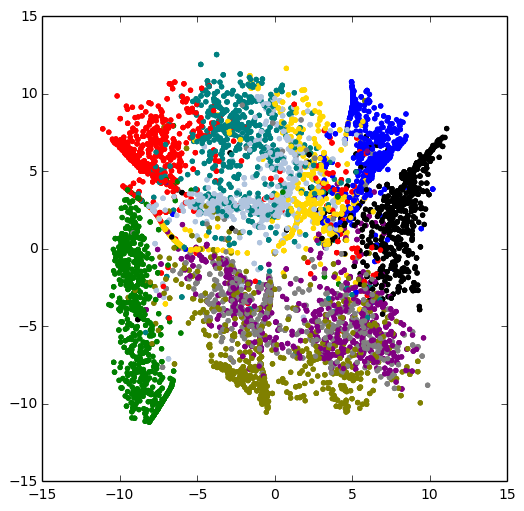

In [51]:
def plot():
    z_batches = []
    colors = []
    for i in xrange(200):
        batch = data.validation.next_batch(BATCH_SIZE)
        z_value = sess.run(z, feed_dict={x: batch[0]})
        z_batches.append(z_value)
        colors.extend(label_batch_to_colors(batch[1]))
    z_array = np.concatenate(z_batches, axis=0)
    dim1 = z_array[:, 0]
    dim2 = z_array[:, 1]
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, aspect='equal')
    plot = ax.scatter(dim1, dim2, c=colors, s=15, linewidths=0)
    
plot()

We can see that the entire set of z points is distributed approximately according to the 2D uniform distribution that we imposed as the prior, which is what we wanted. Furthermore, the images have been roughly clustered by label, even though the model does not have access to any label information. This is a byproduct of minimizing reconstruction error: similar images will have similar z codes so that the network can compactly encode an image.

Also, notice that there are very few gaps in the distribution of points, which is an effect of us forcing the aggregate posterior of z to match the imposed prior. This means we could do something like sample a random value of z, and then run it through the decoder to generate a new image from scratch. With a normal autoencoder, there is no guarantee that the value of z you sampled will correspond to a meaningful encoding, so in general this type of image generation process will not give good results if done with a normal autoencoder.

We can visualize the learned data manifold by evenly sampling a grid of z points, and running them through the decoder. Let's try it:

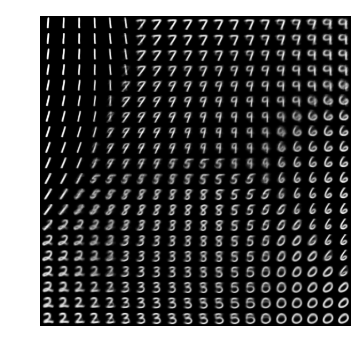

In [52]:
im_per_side = 20
scale = 10
z_point = np.array([[-2, 1]])
xx, yy = np.meshgrid(np.linspace(-scale, scale, im_per_side), np.linspace(-scale, scale, im_per_side))
imgrid = np.zeros((28*im_per_side, 28*im_per_side))
for i in xrange(im_per_side):
    for j in xrange(im_per_side):
        z_point = [[xx[i,j], yy[i,j]]]
        im = sess.run(x_decoded, feed_dict={z: z_point})
        imgrid[28*i:28*i+28, 28*j:28*j+28] = im.reshape((28,28))
plt.imshow(imgrid, cmap='gray')
_ = plt.axis('off')

Notice that not only are digits clustered according to class, but the writing style of a particular digit varies as you move within its cluster. For instance, we can see that the '2' cluster has regions for a 2 written with and without a loop. The '1' cluster has regions encoding the slant of the 1. Furthermore, similar digits smoothly blend into each other. We can see that the 3s, 5s, and 8s are all next to each other, and points on the boundary between these digits correspond to smooth interpolations between the digit classes.

Finally, in order to get a sense of the strengths of an adversarial autoencoder, let's retrain the exact same model as a normal autoencoder. This is very easy to do, we just eliminate the lines of code corresponding to the adversarial training process. I've commented out the two lines that need to be removed.

In [53]:
sess.run(tf.initialize_all_variables())

for i in xrange(STEPS):
    batch = data.train.next_batch(BATCH_SIZE)
    sess.run(autoencoder_train_op, feed_dict={x: batch[0]})
    #sess.run(generator_train_op, feed_dict={x: batch[0]})
    #sess.run(discriminator_train_op, feed_dict={x: batch[0]})

Now let's do the same z distribution plot again, but with a normal autoencoder.

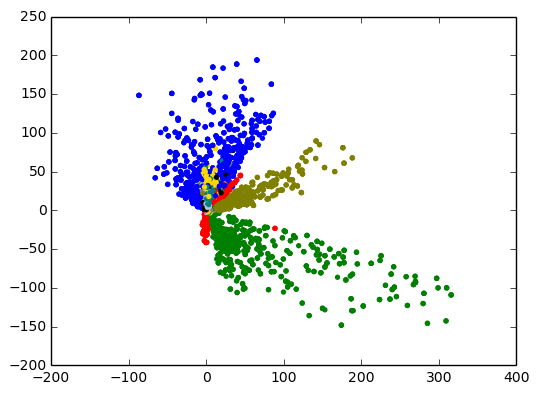

In [54]:
plot()

It looks a lot different from the previous plot. Here, we haven't imposed any prior distribution on z. The encoder is free to use the latent z space however it wants. Images are still roughly clustered by label, but some clusters take up a lot more space than others. The scale is more or less arbitrary, and will vary from run to run. Also, there are large gaps where no points lie.

Think about what might happen if you tried to randomly sample z, and then run it through the decoder to generate a new image. First off, you don't even know what distribution to sample from, and you have no idea what the relative scale of the z-space will be without empirically plotting some points. If you try to sample points anyway, you are a lot more likely to sample a z value that falls in a large, spread out cluster than a small, dense cluster. This means you are more likely to generate some digits than others, even though all digits are equally likely in the training data. Even worse, you might sample a z value that falls in one of the large gaps where there are no points. These empty spaces do not correspond to meaningful encodings. They are effectively regions that the encoder decided not to utilize, for whatever reason. An image generated by running such a z value through the decoder would most likely not be a valid digit. Because of all these effects, a normal autoencoder is not a generative model, but an adversarial autoencoder is.

## Further Resources

Because adversarial autoencoders are a very recent technique, I think the best way to learn about them is to read the [original paper](https://arxiv.org/abs/1511.05644). Another autoencoder model that does the same thing as adversarial autoencoders, but in a different way, is the [variational autoencoder](https://arxiv.org/abs/1312.6114). The main idea behind adversarial autoencoders was to take techniques from Generative Adversarial Networks and apply them as a latent variable regularizer for autoencoders. As such, reading and understanding the [GAN paper](https://arxiv.org/abs/1406.2661) is very useful for understanding adversarial autoencoders in depth.

## References

[1] Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., and Frey, B. (2016). Adversarial Autoencoders. 	*arXiv:1511.05644.*

[2] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., and Bengio, Y. (2014). Generative Adversarial Networks. *arXiv:1406.2661.*